In [1]:
import queue
import threading
import time
import traceback
from enum import IntEnum
from typing import Optional

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pyaudio
import scipy
from tqdm import tqdm

CHANNELS = 1
SAMPLE_RATE = 24000
FRAME_RATE = 30
HOP_LENGTH = SAMPLE_RATE // FRAME_RATE
N_FFT = 2 * HOP_LENGTH
N_MELS = 66
NORM = np.inf
CHUNK_SIZE = 4 * HOP_LENGTH
FRAME_RATE = SAMPLE_RATE / HOP_LENGTH
DTW_WINDOW_SIZE = int(3 * FRAME_RATE)
METRIC = "euclidean"
MAX_RUN_COUNT = 30
FEATURES = ["chroma"]  # chroma, mel, mfcc, etc.

In [2]:
def process_chroma(y):
    chroma_stft = librosa.feature.chroma_stft(
        y=y,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        n_fft=N_FFT,
        norm=NORM,
        center=False,
    )
    return chroma_stft


def process_mfcc(y):
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        center=False,
    )
    return np.log1p(mfcc * 5) / 4


def process_mel(y):
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        n_fft=N_FFT,
        norm=NORM,
        n_mels=N_MELS,
        center=False,
    )
    return np.log1p(mel * 5) / 4


class StreamProcessor:
    def __init__(
        self,
        sample_rate,
        chunk_size,
        hop_length,
        n_fft,
        additional_buffer=HOP_LENGTH,
        verbose=False,
        features=["chroma"],  # "chroma", "mel", "mfcc", "whisper", etc.
    ):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.additional_buffer = additional_buffer
        self.verbose = verbose
        self.features = features
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.feature_buffer = queue.Queue()
        self.last_chunk = None
        self.index = 0
        self.mock = False

    def _process_feature(self, y, time_info=None):
        if self.last_chunk is None:  # add zero padding at the first block
            y = np.concatenate((np.zeros(self.hop_length), y))
        else:
            # add last chunk at the beginning of the block
            # making 5 block, 1 block overlap -> 4 frames each time
            y = np.concatenate((self.last_chunk, y))

        y_feature = None
        for feature in self.features:
            if feature == "chroma":
                y_chroma = process_chroma(y)
                # print(f"StreamProcessor:y_chroma.shape: {y_chroma.shape}")
                y_feature = (
                    y_chroma if y_feature is None else np.vstack((y_feature, y_chroma))
                )
            elif feature == "mel":
                y_mel = process_mel(y)
                y_feature = (
                    y_mel if y_feature is None else np.vstack((y_feature, y_mel))
                )
            elif feature == "mfcc":
                y_mfcc = process_mfcc(y)
                y_feature = (
                    y_mfcc if y_feature is None else np.vstack((y_feature, y_mfcc))
                )

        current_chunk = {
            "timestamp": time_info if time_info else time.time(),
            "feature": y_feature[
                :, -int(self.chunk_size / self.hop_length) :
            ],  # trim to chunk_size
        }
        self.feature_buffer.put(current_chunk)
        self.last_chunk = y[-self.additional_buffer :]
        self.index += 1

    def _process_frame(self, data, frame_count, time_info, status_flag):
        if self.verbose:
            print(f"\nprocess_frame index: {self.index}, frame_count: {frame_count}")
            print(f"{self.index}st time_info: {time_info}")

        target_audio = np.frombuffer(data, dtype=np.float32)  # initial y
        self.buffer.put(target_audio)
        self._process_feature(target_audio, time_info["input_buffer_adc_time"])

        return (data, pyaudio.paContinue)

    def mock_stream(self, file_path):
        duration = int(librosa.get_duration(path=file_path))
        audio_y, _ = librosa.load(file_path, sr=self.sample_rate)
        padded_audio = np.concatenate(
            (audio_y, np.zeros(duration * 2 * self.sample_rate))
        )
        trimmed_audio = padded_audio[
            : len(padded_audio) - (len(padded_audio) % self.chunk_size)
        ]
        while trimmed_audio.any():
            audio_chunk = trimmed_audio[: self.chunk_size]
            time_info = {"input_buffer_adc_time": time.time()}
            self._process_feature(audio_chunk, time_info)
            trimmed_audio = trimmed_audio[self.chunk_size :]
            self.index += 1

        # fill empty values with zeros after stream is finished
        additional_padding_size = duration * 2 * self.sample_rate
        while additional_padding_size > 0:
            time_info = {"input_buffer_adc_time": time.time()}
            self._process_feature(
                np.zeros(self.chunk_size),
                time_info,
            )
            additional_padding_size -= self.chunk_size

    def run(self, mock=False, mock_file=""):
        if mock:  # mock processing
            print(f"* [Mocking] Loading existing audio file({mock_file})....")
            self.mock = True
            x = threading.Thread(target=self.mock_stream, args=(mock_file,))
            x.start()
            return

        # real-time processing
        self.audio_interface = pyaudio.PyAudio()
        self.audio_stream = self.audio_interface.open(
            format=self.format,
            channels=self.channels,
            rate=self.sample_rate,
            input=True,
            frames_per_buffer=self.hop_length * 4,
            stream_callback=self._process_frame,
        )
        self.audio_stream.start_stream()
        self.start_time = self.audio_stream.get_time()
        if self.verbose:
            print("* Recording in progress....")

    def stop(self):
        if not self.mock:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.mock = False
            self.audio_interface.terminate()
            if self.verbose:
                print("Recording Stopped.")

In [3]:
class Direction(IntEnum):
    REF = 1
    QUERY = 2


class OLTW:
    def __init__(
        self,
        sp: StreamProcessor,
        ref_audio_path,
        window_size=DTW_WINDOW_SIZE,
        sample_rate=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        max_run_count=MAX_RUN_COUNT,
        metric=METRIC,
        features=FEATURES,
    ):
        self.sp = sp
        self.ref_audio_file = ref_audio_path
        self.w = window_size
        self.max_run_count = max_run_count
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.frame_rate = self.sample_rate / self.hop_length
        self.frame_per_seg = int(sp.chunk_size / self.hop_length)  # 4
        self.metric = metric
        self.features = features
        self.ref_pointer = 0
        self.target_pointer = 0
        self.run_count = 0
        self.previous_direction = None
        self.target_features = None  # (12, N) stft of total target
        self.dist_matrix = None
        self.acc_dist_matrix = None
        self.candidate = None
        self.candi_history = [[0, 0]]
        self.iteration = 0

        self.initialize_ref_audio(ref_audio_path)

    def offset(self):
        offset_x = max(self.ref_pointer - self.w, 0)
        offset_y = max(self.target_pointer - self.w, 0)
        return np.array([offset_x, offset_y])

    def initialize_ref_audio(self, audio_path):
        audio_y, _ = librosa.load(audio_path, sr=self.sample_rate)
        audio_y = np.concatenate((np.zeros(self.hop_length), audio_y))
        ref_feature = None
        for feature in self.features:
            if feature == "chroma":
                y_chroma = process_chroma(audio_y)
                # print(f"OLTW:y_chroma.shape: {y_chroma.shape}")
                ref_feature = (
                    y_chroma
                    if ref_feature is None
                    else np.vstack((ref_feature, y_chroma))
                )
            elif feature == "mel":
                y_mel = process_mel(audio_y)
                ref_feature = (
                    y_mel if ref_feature is None else np.vstack((ref_feature, y_mel))
                )
            elif feature == "mfcc":
                y_mfcc = process_mfcc(audio_y)
                ref_feature = (
                    y_mfcc if ref_feature is None else np.vstack((ref_feature, y_mfcc))
                )
        ref_len = ref_feature.shape[1]
        truncated_len = (
            (ref_len - 1) // self.frame_per_seg
        ) * self.frame_per_seg  # initialize_ref_audio 에서 ref_stft 길이가 frame_per_seg (4) 로 나눠지게 마지막을 버림
        self.ref_features = ref_feature[:, :truncated_len]
        self.ref_total_length = self.ref_features.shape[1]

        self.global_cost_matrix = np.zeros(
            (self.ref_total_length * 2, self.ref_total_length * 2)
        )
        # self.target_features = np.zeros((12, self.ref_total_length * 2))
        self.target_features = np.zeros(
            (self.ref_features.shape[0], self.ref_total_length * 2)
        )

    def init_dist_matrix(self):
        ref_stft_seg = self.ref_features[:, : self.ref_pointer]  # [F, M]
        target_stft_seg = self.target_features[:, : self.target_pointer]  # [F, N]
        dist = scipy.spatial.distance.cdist(
            ref_stft_seg.T, target_stft_seg.T, metric=self.metric
        )
        self.dist_matrix[self.w - dist.shape[0] :, self.w - dist.shape[1] :] = dist

    def init_matrix(self):
        x = self.ref_pointer
        y = self.target_pointer
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))
        x_seg = self.ref_features[:, x - wx : x].T  # [wx, 12]
        y_seg = self.target_features[:, min(y - d, 0) : y].T  # [d, 12]
        dist = scipy.spatial.distance.cdist(x_seg, y_seg, metric=self.metric)  # [wx, d]

        for i in range(wx):
            for j in range(d):
                local_dist = dist[i, j]
                update_x0 = 0
                update_y0 = wy - d
                if i == 0 and j == 0:
                    new_acc[i, j] = local_dist
                elif i == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i, update_y0 - 1]
                    new_len_acc[i, update_y0 + j] = 1 + new_len_acc[i, update_y0 - 1]
                elif j == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i - 1, update_y0]
                    new_len_acc[i, update_y0 + j] = (
                        local_dist + new_len_acc[i - 1, update_y0]
                    )
                else:
                    compares = [
                        new_acc[i - 1, update_y0 + j],
                        new_acc[i, update_y0 + j - 1],
                        new_acc[i - 1, update_y0 + j - 1] * 0.98,
                    ]
                    len_compares = [
                        new_len_acc[i - 1, update_y0 + j],
                        new_len_acc[i, update_y0 + j - 1],
                        new_len_acc[i - 1, update_y0 + j - 1],
                    ]
                    local_direction = np.argmin(compares)
                    new_acc[i, update_y0 + j] = local_dist + compares[local_direction]
                    new_len_acc[i, update_y0 + j] = 1 + len_compares[local_direction]
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc
        self.select_candidate()

    def update_accumulate_matrix(self, direction):
        # local cost matrix
        x = self.ref_pointer
        y = self.target_pointer
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))

        if direction is Direction.REF:
            new_acc[:-d, :] = self.acc_dist_matrix[d:]
            new_len_acc[:-d, :] = self.acc_len_matrix[d:]
            x_seg = self.ref_features[:, x - d : x].T  # [d, 12]
            y_seg = self.target_features[:, y - wy : y].T  # [wy, 12]
            dist = scipy.spatial.distance.cdist(
                x_seg, y_seg, metric=self.metric
            )  # [d, wy]

            for i in range(d):
                for j in range(wy):
                    local_dist = dist[i, j]
                    update_x0 = wx - d
                    update_y0 = 0
                    if j == 0:
                        new_acc[update_x0 + i, j] = (
                            local_dist + new_acc[update_x0 + i - 1, j]
                        )
                        new_len_acc[update_x0 + i, j] = (
                            new_len_acc[update_x0 + i - 1, j] + 1
                        )
                    else:
                        compares = [
                            new_acc[update_x0 + i - 1, j],
                            new_acc[update_x0 + i, j - 1],
                            new_acc[update_x0 + i - 1, j - 1] * 0.98,
                        ]
                        len_compares = [
                            new_len_acc[update_x0 + i - 1, j],
                            new_len_acc[update_x0 + i, j - 1],
                            new_len_acc[update_x0 + i - 1, j - 1],
                        ]
                        local_direction = np.argmin(compares)
                        new_acc[update_x0 + i, j] = (
                            local_dist + compares[local_direction]
                        )
                        new_len_acc[update_x0 + i, j] = (
                            1 + len_compares[local_direction]
                        )

        elif direction is Direction.QUERY:
            overlap_y = wy - d
            new_acc[:, :-d] = self.acc_dist_matrix[:, -overlap_y:]
            new_len_acc[:, :-d] = self.acc_len_matrix[:, -overlap_y:]
            x_seg = self.ref_features[:, x - wx : x].T  # [wx, 12]
            y_seg = self.target_features[:, y - d : y].T  # [d, 12]
            dist = scipy.spatial.distance.cdist(
                x_seg, y_seg, metric=self.metric
            )  # [wx, d]

            for i in range(wx):
                for j in range(d):
                    local_dist = dist[i, j]
                    update_x0 = 0
                    update_y0 = wy - d
                    if i == 0:
                        new_acc[i, update_y0 + j] = (
                            local_dist + new_acc[i, update_y0 - 1]
                        )
                        new_len_acc[i, update_y0 + j] = (
                            1 + new_len_acc[i, update_y0 - 1]
                        )
                    else:
                        compares = [
                            new_acc[i - 1, update_y0 + j],
                            new_acc[i, update_y0 + j - 1],
                            new_acc[i - 1, update_y0 + j - 1] * 0.98,
                        ]
                        len_compares = [
                            new_len_acc[i - 1, update_y0 + j],
                            new_len_acc[i, update_y0 + j - 1],
                            new_len_acc[i - 1, update_y0 + j - 1],
                        ]
                        local_direction = np.argmin(compares)
                        new_acc[i, update_y0 + j] = (
                            local_dist + compares[local_direction]
                        )
                        new_len_acc[i, update_y0 + j] = (
                            1 + len_compares[local_direction]
                        )
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc

    def update_path_cost(self, direction):
        self.update_accumulate_matrix(direction)
        self.select_candidate()

    def select_candidate(self):
        norm_x_edge = self.acc_dist_matrix[-1, :] / self.acc_len_matrix[-1, :]
        norm_y_edge = self.acc_dist_matrix[:, -1] / self.acc_len_matrix[:, -1]
        cat = np.concatenate((norm_x_edge, norm_y_edge))
        min_idx = np.argmin(cat)
        offset = self.offset()
        if min_idx <= len(norm_x_edge):
            self.candidate = np.array([self.ref_pointer - offset[0], min_idx])
        else:
            self.candidate = np.array(
                [min_idx - len(norm_x_edge), self.target_pointer - offset[1]]
            )

    def save_history(self):
        self.candi_history.append(self.offset() + self.candidate)

    def select_next_direction(self):
        if self.target_pointer <= self.w:
            next_direction = Direction.QUERY
        elif self.run_count > self.max_run_count:
            next_direction = (
                Direction.QUERY
                if self.previous_direction is Direction.REF
                else Direction.REF
            )
        else:
            offset = self.offset()
            x0, y0 = offset[0], offset[1]
            if self.candidate[0] == self.ref_pointer - x0:
                next_direction = Direction.REF
            else:
                assert self.candidate[1] == self.target_pointer - y0
                next_direction = Direction.QUERY
        return next_direction

    def get_new_input(self):
        # NOTE getting new chunk of features from the queue
        target_feature = self.sp.feature_buffer.get()["feature"]
        q_length = self.frame_per_seg
        self.target_features[
            :, self.target_pointer : self.target_pointer + q_length
        ] = target_feature
        self.target_pointer += q_length

    def _is_still_following(self):
        return self.ref_pointer <= (self.ref_total_length - self.frame_per_seg)

    def run(self, fig=None, h=None, hfig=None, mock=False, mock_audio_path=""):
        pbar = tqdm(total=self.ref_total_length)
        self.sp.run(mock=mock, mock_file=mock_audio_path)  # mic ON

        self.ref_pointer += self.w
        self.get_new_input()
        self.init_matrix()
        last_ref_checkpoint = 0
        while self._is_still_following():
            pbar.update(self.candi_history[-1][0] - last_ref_checkpoint)
            pbar.set_description(
                f"[{self.ref_pointer}/{self.ref_total_length}] ref: {self.ref_pointer}, target: {self.target_pointer}"
            )
            last_ref_checkpoint = self.candi_history[-1][0]
            self.save_history()
            direction = self.select_next_direction()

            if direction is Direction.QUERY:
                self.get_new_input()
                self.update_path_cost(direction)
            elif direction is Direction.REF:
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            if direction == self.previous_direction:
                self.run_count += 1
            else:
                self.run_count = 1

            self.previous_direction = direction
            self.iteration += 1

            duration = int(librosa.get_duration(path=self.ref_audio_file)) + 1
            if h and hfig and fig:
                h.set_data(self.target_features[:, : int(self.frame_rate) * duration])
                hfig.update(fig)

        pbar.close()
        self.stop()

    def stop(self):
        self.sp.stop()

## Run Test (Live)
You may play the audio file (or instrument) to computer mic stream.

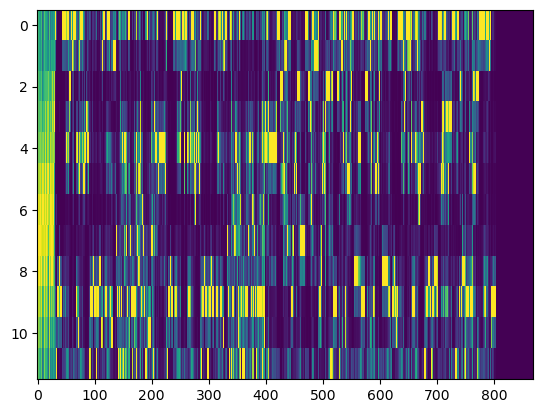

  0%|          | 0/952 [00:00<?, ?it/s]/Users/jiyun/.pyenv/versions/mambaforge/envs/match/lib/python3.9/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
[90/952] ref: 90, target: 4:   0%|          | 0/952 [00:00<?, ?it/s]

* [Mocking] Loading existing audio file(./resources/performance_audio.wav)....


[946/952] ref: 946, target: 888:  99%|█████████▉| 943/952 [00:21<00:00, 44.04it/s]


=====================oltw run ended=====================


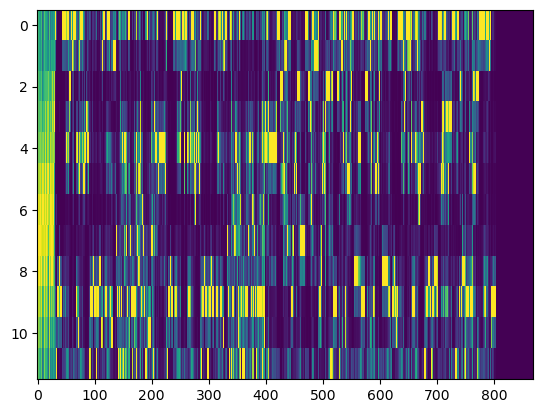

In [4]:
ref_audio_path = "./resources/score_audio.wav"
target_audio_path = "./resources/performance_audio.wav"
duration = int(librosa.get_duration(path=target_audio_path))
sp = StreamProcessor(
    sample_rate=SAMPLE_RATE,
    chunk_size=CHUNK_SIZE,
    hop_length=HOP_LENGTH,
    n_fft=N_FFT,
    features=FEATURES,
)
oltw = OLTW(
    sp,
    ref_audio_path,
    window_size=DTW_WINDOW_SIZE,
    sample_rate=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    max_run_count=30,
    metric="euclidean",
    features=FEATURES,
)
fig = plt.figure()
ax = fig.gca()
hfig = display(fig, display_id=True)
h = ax.imshow(
    np.zeros((12, int(SAMPLE_RATE / HOP_LENGTH) * duration)),
    aspect="auto",
    vmin=0,
    vmax=1,
    interpolation="nearest",
)

try:
    oltw.run(fig, h, hfig, mock=True, mock_audio_path=target_audio_path)
except Exception as e:
    print(f"error! : {str(e)}, {type(e)}")
    traceback.print_tb(e.__traceback__)
    oltw.stop()

print(f"=====================oltw run ended=====================")

/var/folders/qt/9fbsg60j1nq11b6lhq5t9zrm0000gn/T/ipykernel_47365/1752924499.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter', 100)


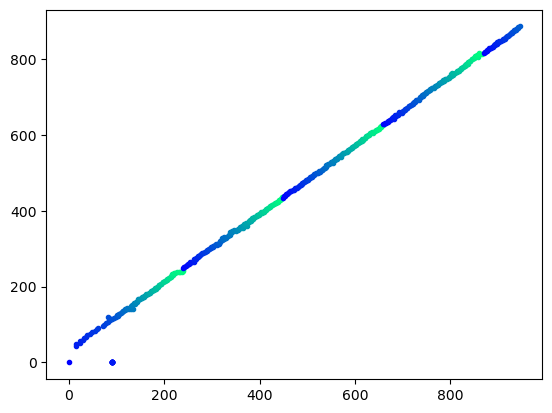

In [5]:
x,y  = zip(*oltw.candi_history)

from matplotlib import cm
cmap = cm.get_cmap('winter', 100)
for n in range(len(x)):
    plt.plot(x[n], y[n], '.', color=cmap(n%100))

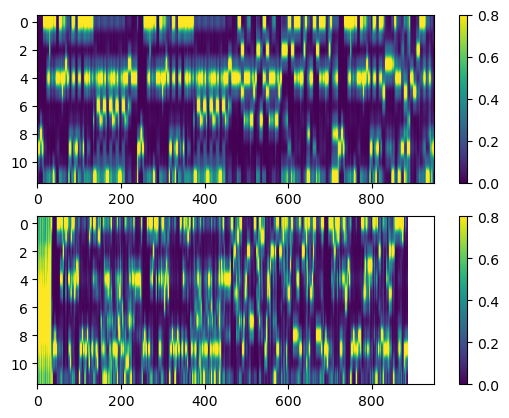

In [6]:
max_step = np.max((oltw.ref_pointer, oltw.target_pointer))
# max_step = np.min((oltw.ref_pointer, oltw.query_pointer))
plt.subplot(211)
plt.imshow(oltw.ref_features[:, :oltw.ref_pointer], aspect='auto', vmin=0, vmax=0.8)
plt.xlim(0,max_step)
plt.colorbar()
plt.subplot(212)
plt.imshow(oltw.target_features[:, :oltw.target_pointer], aspect='auto', vmin=0, vmax=0.8)
plt.xlim(0,max_step)
plt.colorbar()

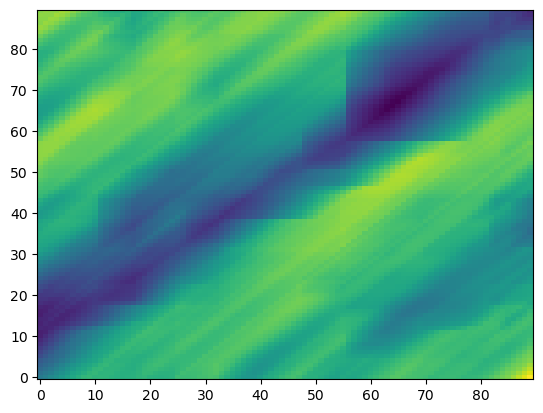

In [7]:
plt.imshow(oltw.acc_dist_matrix.T, aspect='auto', origin='lower')

/var/folders/qt/9fbsg60j1nq11b6lhq5t9zrm0000gn/T/ipykernel_47365/1655750115.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', 100)


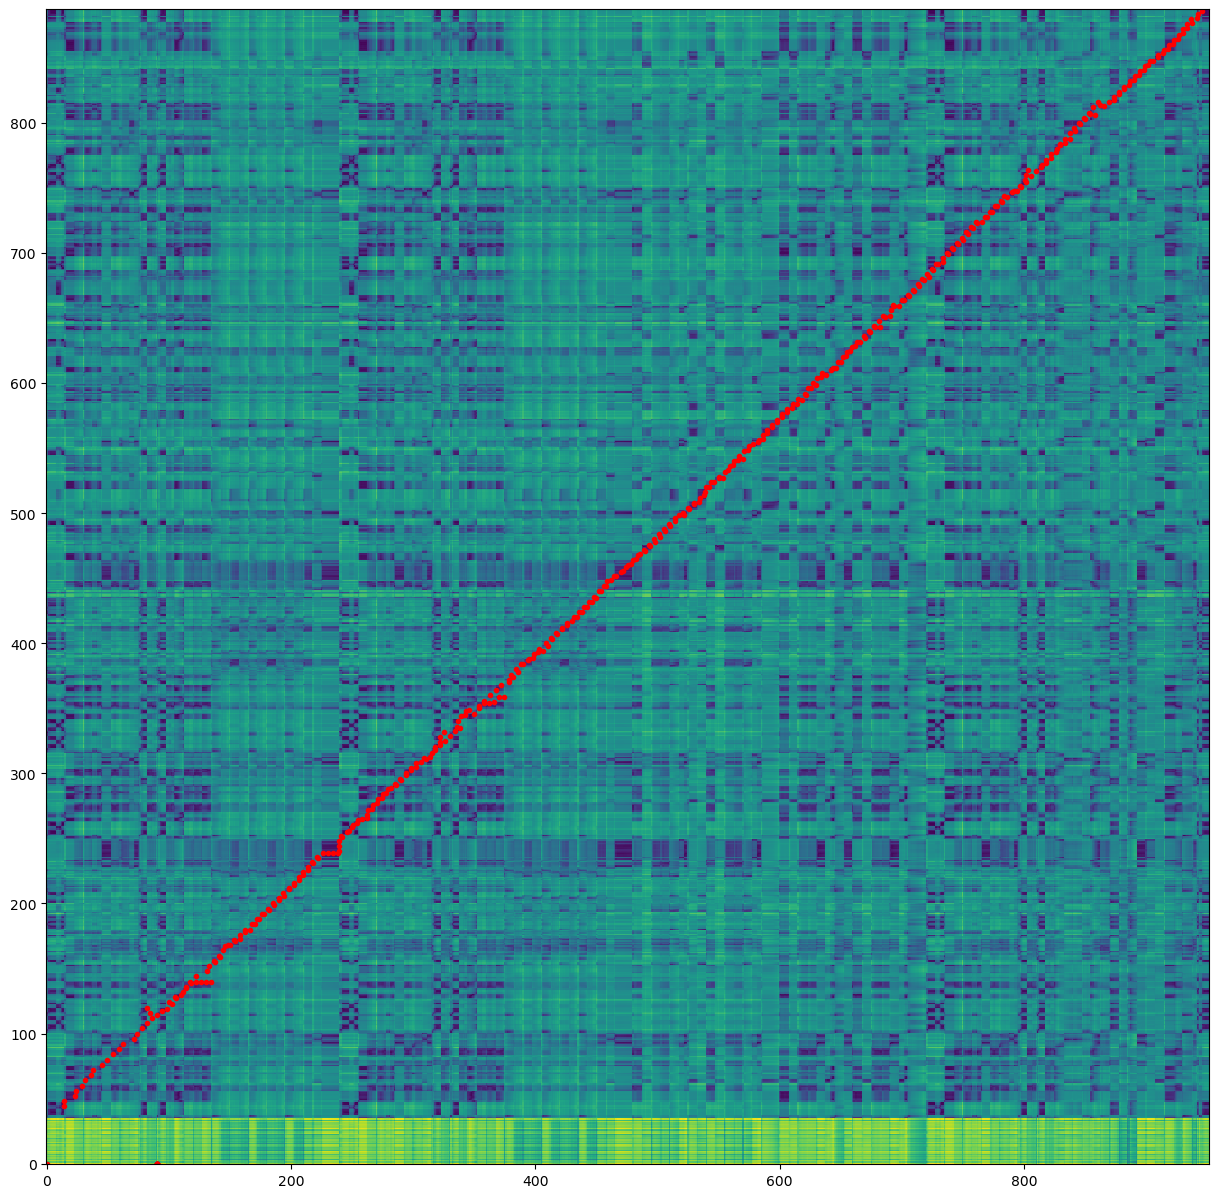

In [8]:
dist = scipy.spatial.distance.cdist(oltw.ref_features.T, oltw.target_features[:, :oltw.target_pointer].T)  # [d, wy]
plt.figure(figsize=(15, 15))
plt.imshow(dist.T, aspect='auto', origin='lower', interpolation='nearest')
x,y  = zip(*oltw.candi_history)

from matplotlib import cm
cmap = cm.get_cmap('magma', 100)
for n in range(len(x)):
    plt.plot(x[n], y[n], '.', color='r')

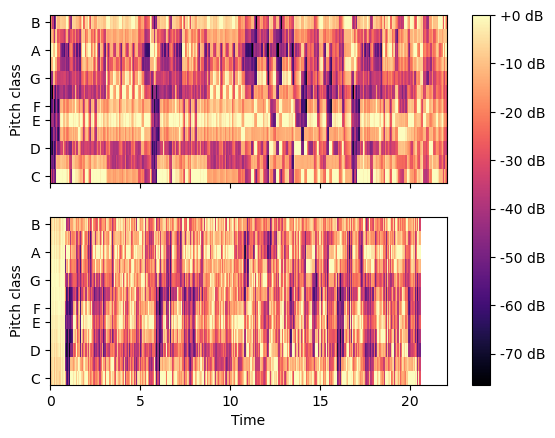

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D1 = librosa.amplitude_to_db(np.abs(oltw.ref_features[:, :oltw.ref_pointer]))
img = librosa.display.specshow(D1, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].label_outer()

D2 = librosa.amplitude_to_db(np.abs(oltw.target_features[:, :oltw.target_pointer]))
img = librosa.display.specshow(D2, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")